# Analysis of Benchmarking Results for Partitioned LSMTree

In [1]:
import os.path
import json
from glob import glob
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns

plt.style.use(['fivethirtyeight'])


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 400)
pd.set_option('display.max_colwidth', 100)

colors = [c['color'] for c in plt.rcParams['axes.prop_cycle']]
ops = ['put', 'get', 'delete']

In [2]:
background_color = '#fcfcfc'
old_background_color = plt.rcParams['axes.edgecolor']
for k,v in plt.rcParams.items():
    if v == old_background_color:
        plt.rcParams[k] = background_color

In [3]:
figdir = 'figures/partitioned_lsm'
!mkdir -p $figdir

# Loading Data

In [4]:
specs = pd.read_json('results/partitioned_lsm/benchmark_part_lsm_specs.jsonl', lines=True)
print(len(specs))
specs.head()

128


,spec,created_at,events,id,last_modified,status
0,"{'partitions': 16, 'seconds': 3600, 'value_length': 1024, 'key_space_size': 100000000, 'known_ke...",2020-05-02 13:08:45.687435,"[{'msg': 'starting', 'hostname': 'ec2-54-191-160-143.us-west-2.compute.amazonaws.com', 'time': '...",0dfc0d22-8c76-11ea-b1d1-00155d010301,2020-05-02T14:15:22.096517,succeeded
1,"{'partitions': 8, 'seconds': 3600, 'value_length': 1024, 'key_space_size': 100000000, 'known_key...",2020-04-30 08:59:00.321243,"[{'msg': 'Cancelled as duplicate', 'hostname': 'master', 'time': '2020-04-30T09:35:57.903595'}]",d4712913-8ac0-11ea-b1d1-00155d010301,2020-04-30T09:35:57.903595,cancelled
2,"{'partitions': 4, 'seconds': 3600, 'value_length': 1024, 'key_space_size': 100000000, 'known_key...",2020-04-29 20:48:46.571357,"[{'msg': 'starting', 'hostname': 'ec2-35-164-210-77.us-west-2.compute.amazonaws.com', 'time': '2...",58db5279-8a7c-11ea-b1d1-00155d010301,2020-04-30T01:53:17.412197,succeeded
3,"{'partitions': 16, 'seconds': 3600, 'value_length': 1024, 'key_space_size': 100000000, 'known_ke...",2020-05-02 13:08:46.435927,"[{'msg': 'starting', 'hostname': 'ec2-54-187-66-184.us-west-2.compute.amazonaws.com', 'time': '2...",0dfc0d2b-8c76-11ea-b1d1-00155d010301,2020-05-02T14:15:17.632359,succeeded
4,"{'partitions': 8, 'seconds': 3600, 'value_length': 1024, 'key_space_size': 100000000, 'known_key...",2020-04-30 08:59:00.805861,"[{'msg': 'Cancelled as duplicate', 'hostname': 'master', 'time': '2020-04-30T09:35:57.990984'}]",d4712919-8ac0-11ea-b1d1-00155d010301,2020-04-30T09:35:57.990984,cancelled


In [5]:
specs['status'].value_counts()

succeeded    80
cancelled    45
failed        3
Name: status, dtype: int64

In [6]:
results = pd.read_json('results/partitioned_lsm/benchmark_part_lsm_results.jsonl', lines=True, convert_dates=False)
print(len(results))
results.sample(5)

30708


,delete,get_found,spec_id,delete_found,get,file_size,put,nano_time
2295,652661,32098,5b6b2916-8ac6-11ea-b1d1-00155d010301,652661,144681,44973269796,652607,5155226839943
13386,53253,115681,5b6b290f-8ac6-11ea-b1d1-00155d010301,53253,904916,19484993719,107061,9955949899046
21564,81873,264108,5b6b2907-8ac6-11ea-b1d1-00155d010301,81873,1397616,37677479004,165014,3702566497430
21580,2102406,33059,0dfc0d30-8c76-11ea-b1d1-00155d010301,2102406,466635,11064933684,2102684,255902444998
16128,802944,207722,0dfc0d31-8c76-11ea-b1d1-00155d010301,802944,824881,52245476245,802077,1369028560968


## Preprocess Results

In [7]:
constant_parameters = ['seconds', 'value_length', 'key_space_size', 'known_key_rate_percent', 'trial_index',
                       'pending_write_merge_threshold', 'index_rate']

In [8]:
spec_values = pd.concat([specs[['id', 'status']], pd.DataFrame(list(specs['spec']), index=specs.index)], axis=1)
spec_values['workload'] = spec_values['put_del_get']
spec_values['index_rate'] = spec_values['base_index_rate']
spec_values = spec_values.drop(['put_del_get', 'base_index_rate'], axis=1)
for param in constant_parameters:
    assert spec_values[param].nunique() == 1, f'{param} is not constant'
spec_values = spec_values.drop(constant_parameters, axis=1)
spec_values.sample(5)

,id,status,partitions,thread_count,workload
60,d4712911-8ac0-11ea-b1d1-00155d010301,cancelled,1,1,BALANCED
99,d471290a-8ac0-11ea-b1d1-00155d010301,cancelled,8,8,BALANCED
28,d59e1545-8ac0-11ea-b1d1-00155d010301,cancelled,1,32,BALANCED
30,58db527d-8a7c-11ea-b1d1-00155d010301,succeeded,8,16,BALANCED
84,0ec629d8-8c76-11ea-b1d1-00155d010301,failed,16,16,PUT_HEAVY


In [9]:
grouped_results = []
for spec_id, spec_results in results.groupby('spec_id'):
    spec_results = spec_results.sort_values('nano_time')
    spec_results['t'] = (spec_results['nano_time'] - spec_results['nano_time'].iloc[0]) / 1e9
    grouped_results.append({
        'spec_id': spec_id,
        'results': spec_results,
        'final_file_size': spec_results['file_size'][spec_results['t'] > 50 * 60].max(),
        'sum_put': spec_results['put'].sum(),
        'sum_get': spec_results['get'].sum(),
        'sum_delete': spec_results['delete'].sum()
    })
grouped_results = pd.DataFrame(grouped_results)
grouped_results = pd.concat([spec_values.set_index('id'), grouped_results.set_index('spec_id')], axis=1)
grouped_results = grouped_results.dropna()
grouped_results = grouped_results[grouped_results['status'].isin(['succeeded', 'running'])]
grouped_results.sample(5).T

,58db5273-8a7c-11ea-b1d1-00155d010301,0dfc0d2f-8c76-11ea-b1d1-00155d010301,5b6b2905-8ac6-11ea-b1d1-00155d010301,0dfc0d2e-8c76-11ea-b1d1-00155d010301,0ec629d6-8c76-11ea-b1d1-00155d010301
status,succeeded,succeeded,succeeded,succeeded,succeeded
partitions,4,16,8,16,16
thread_count,1,4,1,1,1
workload,BALANCED,PUT_HEAVY,GET_HEAVY,BALANCED,DELETE_HEAVY
results,delete get_found spec_id delete_found get file_si...,delete get_found spec_id delete_found get file_siz...,delete get_found spec_id delete_found get file_si...,delete get_found spec_id delete_found get file_s...,delete get_found spec_id delete_found get file_si...
final_file_size,8.83919e+10,1.47258e+11,2.18507e+10,5.6654e+10,7.48732e+10
sum_put,7.10698e+07,2.89747e+08,2.24637e+07,8.69961e+07,1.53402e+08
sum_get,7.32273e+07,1.60902e+07,1.91052e+08,8.96257e+07,3.40853e+07
sum_delete,7.107e+07,1.60928e+07,1.1238e+07,8.69893e+07,1.53411e+08


In [10]:
grouped_results['status'].value_counts()

succeeded    80
Name: status, dtype: int64

In [11]:
normed_results = grouped_results.copy()
normed_results['duration_seconds'] = normed_results['results'].map(lambda r: r['t'].max())
for op in ops:
    normed_results[op] = normed_results['sum_' + op] / normed_results['duration_seconds'] / 1000
normed_results = normed_results.drop(['results'] + ['sum_' + op for op in ops], axis=1)
normed_results['sum'] = normed_results[ops].sum(axis=1)
normed_results['final_file_size'] /= 1e9
normed_results = normed_results.set_index(['workload', 'partitions', 'thread_count'])
normed_results.sample(5)

status  final_file_size  duration_seconds        put         get     delete         sum
workload     partitions thread_count                                                                                            
GET_HEAVY    1          32            succeeded        47.081315       3590.634591   8.269423   70.287226   4.134205   82.690855
                        8             succeeded        59.137337       3590.557145  10.398139   88.357040   5.198205  103.953384
             8          4             succeeded        74.745918       3590.767194  16.003534  136.033787   8.002108  160.039429
DELETE_HEAVY 8          4             succeeded       126.606550       3592.587871  44.843063    9.964788  44.849700   99.657552
BALANCED     1          4             succeeded        95.148562       3590.659933  21.302694   21.950014  21.305268   64.557976

status  final_file_size  duration_seconds        put         get     delete         sum
workload  partitions thread_count                                                                                            
GET_HEAVY 16         16            succeeded        47.681172       3591.310145  22.302867  189.566083  11.150334  223.019283
                     32            succeeded        70.791387       3590.991873  21.914461  186.275188  10.955782  219.145431
                     8             succeeded        56.850024       3591.289617  20.898180  177.627025  10.447938  208.973143
          8          8             succeeded        88.626872       3590.932949  19.100304  162.339828   9.549986  190.990118
                     16            succeeded        93.531151       3590.810032  18.942879  160.985568   9.472496  189.400942

status  final_file_size  duration_seconds        put        get     delete        sum
workload  partitions thread_count                                                                                          
BALANCED  1          1             succeeded        73.944780       3590.603005  14.655966  15.099651  14.655085  44.410702
GET_HEAVY 1          1             succeeded        25.119769       3590.532457   4.401002  37.414930   2.201009  44.016942
PUT_HEAVY 4          1             succeeded       153.093584       3591.626139  38.720332   2.151660   2.150574  43.022566
          1          1             succeeded       147.616037       3591.010080  33.251394   1.847321   1.848149  36.946864
          16         32            succeeded        68.515332       3246.703169  29.814161   1.656294   1.656330  33.126785

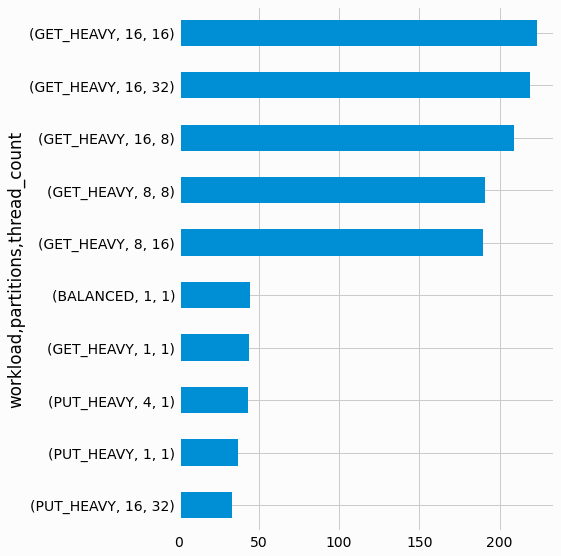

In [12]:
x = normed_results.sort_values('sum', ascending=False)
display(x.head())
display(x.tail())
pd.concat([x['sum'].head(), x['sum'].tail()]).iloc[::-1].plot.barh(figsize=(6,9))

# Analaysis

In [13]:
workload_to_color = {
    'BALANCED': '#008fd5',
    'DELETE_HEAVY': '#fc4f30',
    'PUT_HEAVY': '#e5ae38',
    'GET_HEAVY': '#6d904f'
}
thread_to_color = dict(zip(sorted(set(spec_values['thread_count'])), colors))
partition_to_ls = dict(zip(sorted(set(spec_values['partitions'])), ['-', '--', ':']))
partition_to_marker = dict(zip(sorted(set(spec_values['partitions'])), ['o', 's', '^', '*']))

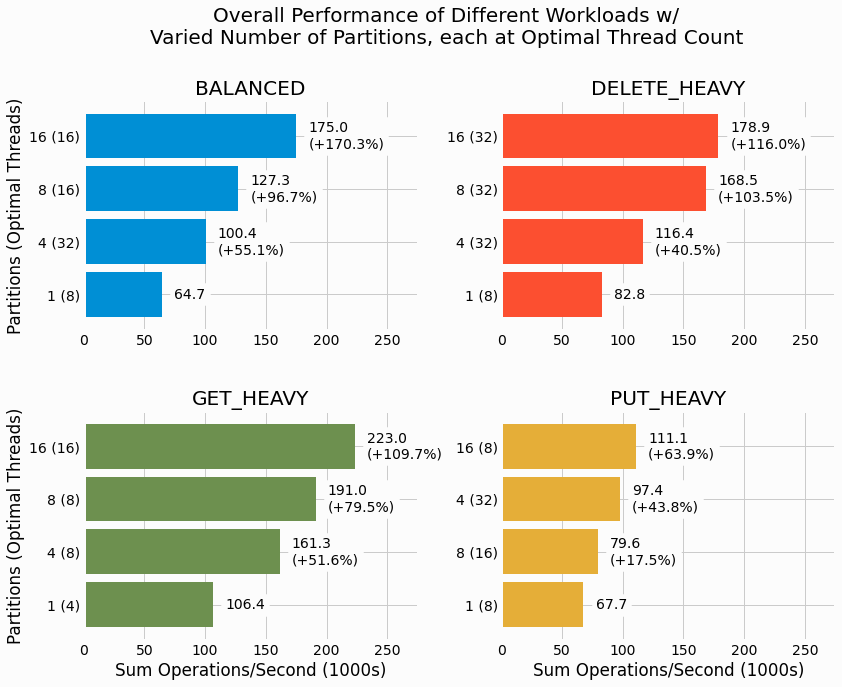

In [14]:
def select_highest_performing_thread_count(df):
    s = df.set_index('thread_count')['sum']
    i = s.idxmax()
    return pd.Series({'thread_count': i, 'sum': s[i]})

def add_bar_values(x, sep='\n'):
    for i, v in enumerate(x):
        ax.text(v + 10, i, f'{v:.1f}' + 
                ('' if i==0 else f'{sep}({100 * (v - x.iloc[0]) / x.iloc[0]:+.1f}%)'), 
                verticalalignment='center',
                bbox=dict(facecolor=background_color, alpha=1))

fig = plt.figure(figsize=(12, 10))
for ax_i, (workload, workload_df) in enumerate( normed_results.groupby('workload')):
    ax = fig.add_subplot(2, 2, 1+ax_i)
    ax.set_title(workload)
    
    workload_df = workload_df.reset_index().groupby('partitions').apply(select_highest_performing_thread_count)
    x = workload_df.reset_index().set_index(['partitions', 'thread_count'])['sum'].sort_values(ascending=True)
    x.plot.barh(ax=ax, color=workload_to_color[workload], width=0.85)
    add_bar_values(x)
    
    ax.set_yticklabels([f'{int(p)} ({int(t)})' for p,t in x.index])
    
    plt.xlim(0, 275)
    if ax_i>=2:
        ax.set_xlabel('Sum Operations/Second (1000s)')
    if ax_i%2==0:
        ax.set_ylabel('Partitions (Optimal Threads)')
    else:
        ax.set_ylabel('')
fig.subplots_adjust(hspace=0.35, top=0.82, wspace=0.25)
fig.suptitle('Overall Performance of Different Workloads w/\n'
             'Varied Number of Partitions, each at Optimal Thread Count', 
             y=0.95, size=20)
plt.savefig(figdir + '/overall_performance.png', bbox_inches='tight')

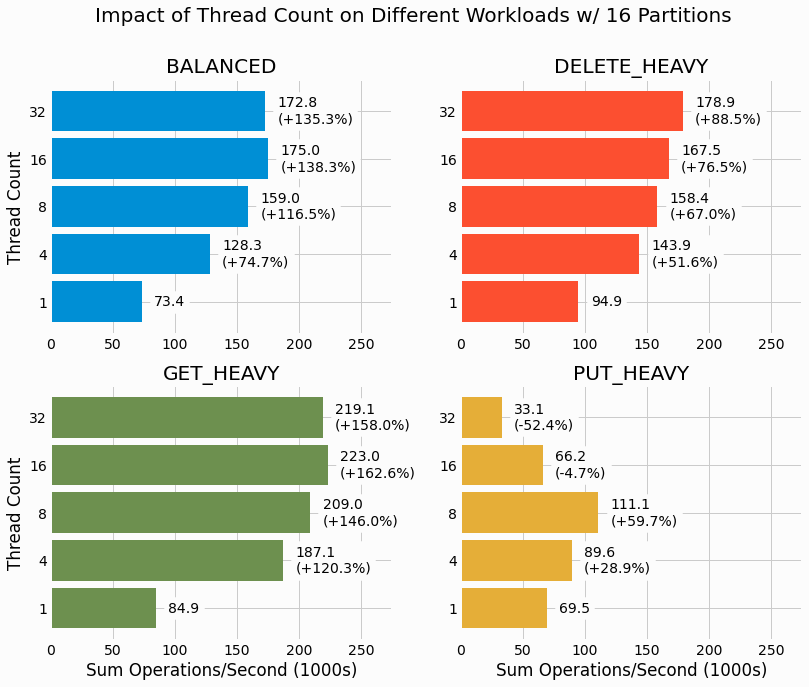

In [15]:
fig = plt.figure(figsize=(12, 10))
x = normed_results.reset_index()
x = x[x['partitions'] == 16]
for ax_i, (workload, workload_df) in enumerate(x.groupby('workload')):
    ax = fig.add_subplot(2, 2, 1+ax_i)
    ax.set_title(workload)
    
    x = workload_df.set_index('thread_count')['sum'].sort_index()
    x.plot.barh(ax=ax, color=workload_to_color[workload], width=0.85)
    add_bar_values(x)
    
    plt.xlim(0, 275)
    if ax_i>=2:
        ax.set_xlabel('Sum Operations/Second (1000s)')
    if ax_i%2==0:
        ax.set_ylabel('Thread Count')
    else:
        ax.set_ylabel('')
fig.subplots_adjust(hspace=0.2, top=0.85)
fig.suptitle('Impact of Thread Count on Different Workloads w/ 16 Partitions', 
             y=0.95, size=20)
plt.savefig(figdir + '/thread_impact_16partitions.png', bbox_inches='tight')

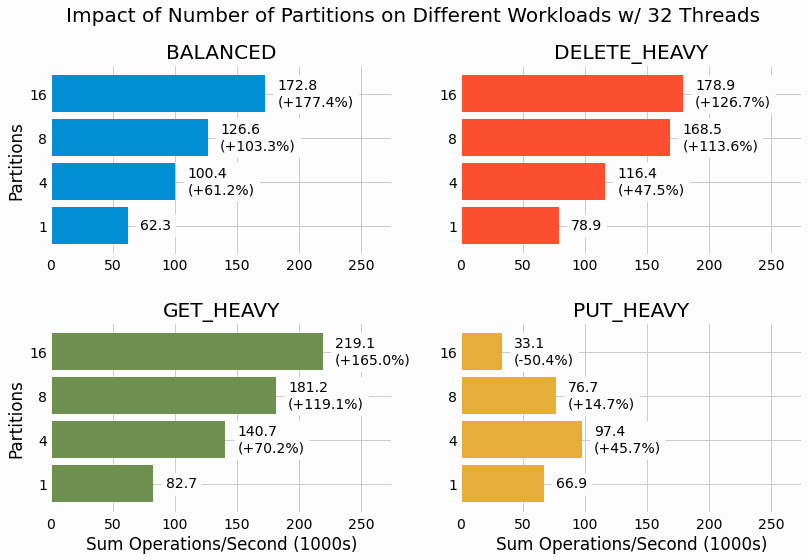

In [16]:
fig = plt.figure(figsize=(12, 8))
x = normed_results.reset_index()
x = x[x['thread_count'] == 32]
for ax_i, (workload, workload_df) in enumerate(x.groupby('workload')):
    ax = fig.add_subplot(2, 2, 1+ax_i)
    ax.set_title(workload)
    
    x = workload_df.set_index('partitions')['sum'].sort_index()
    x.plot.barh(ax=ax, color=workload_to_color[workload], width=0.85)
    add_bar_values(x)
    
    plt.xlim(0, 275)
    if ax_i>=2:
        ax.set_xlabel('Sum Operations/Second (1000s)')
    if ax_i%2==0:
        ax.set_ylabel('Partitions')
    else:
        ax.set_ylabel('')
fig.subplots_adjust(hspace=0.35, top=0.85)
fig.suptitle('Impact of Number of Partitions on Different Workloads w/ 32 Threads', 
             y=0.95, size=20)
plt.savefig(figdir + '/partitions_impact_32threads.png', bbox_inches='tight')

Text(0.5, 0.95, 'Overall Performance of Different Workloads w/ Varied Number of Partitions and Thread Count')

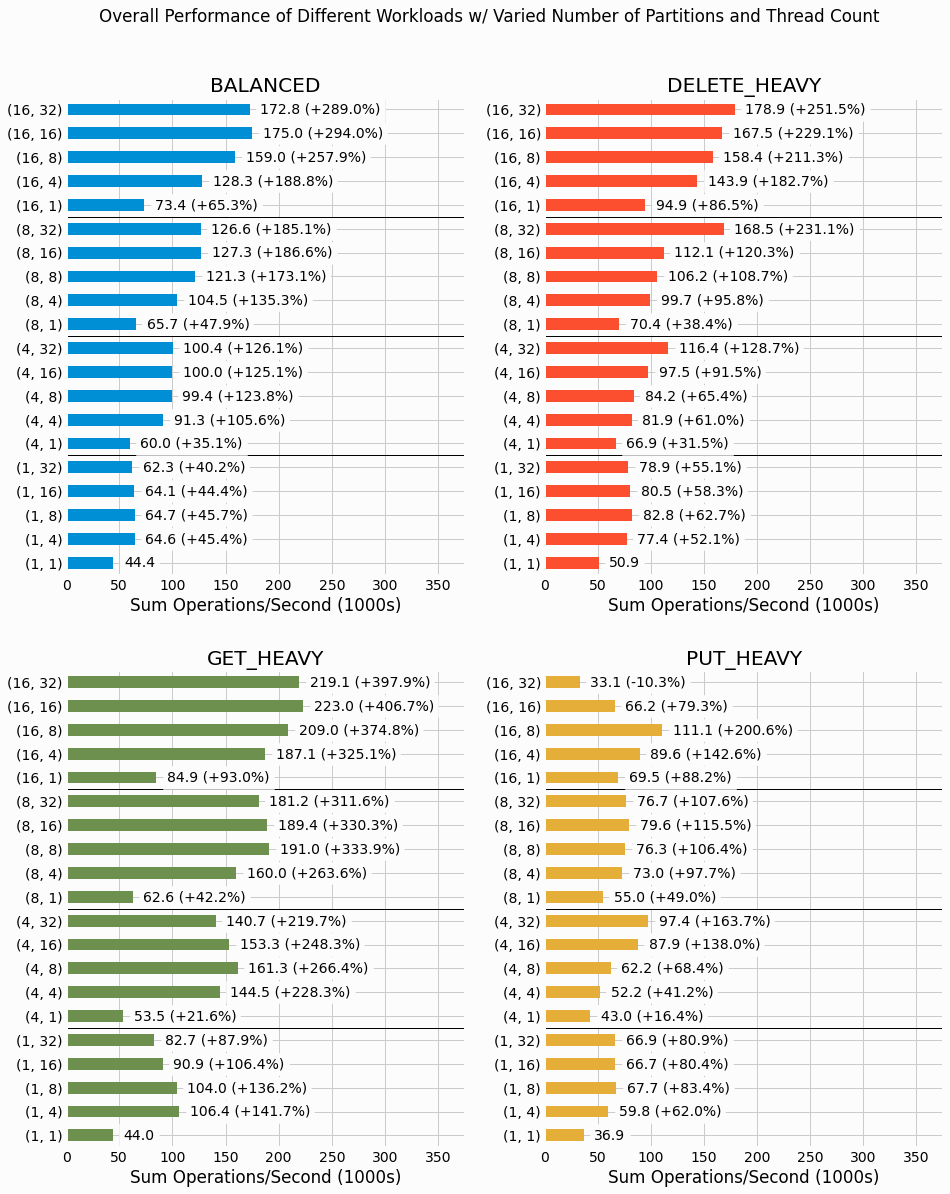

In [17]:
fig = plt.figure(figsize=(14, 18))
for i, (color, (workload, workload_df)) in enumerate(zip(colors, normed_results.groupby('workload'))):
    color = workload_to_color[workload]
    ax = fig.add_subplot(2, 2, i+1)
    ax.set_title(workload)
    workload_df = workload_df.reset_index().set_index(['partitions', 'thread_count']).sort_index()
    x = workload_df['sum']
    x.plot.barh(ax=ax, color=color)
    add_bar_values(x, sep=' ')
    last_p = None
    for i, (p, _) in enumerate(x.index):
        if last_p is not None and last_p != p:
            ax.axhline(i-0.5, color='k', ls='-', lw=1)
        last_p = p
    plt.xlim(0, 375)
    if i>=2:
        ax.set_xlabel('Sum Operations/Second (1000s)')
    if i%2==0:
        ax.set_ylabel('Partitions, Thread Count')
    else:
        ax.set_ylabel('')
fig.suptitle('Overall Performance of Different Workloads w/ Varied Number of Partitions and Thread Count', y=0.95)

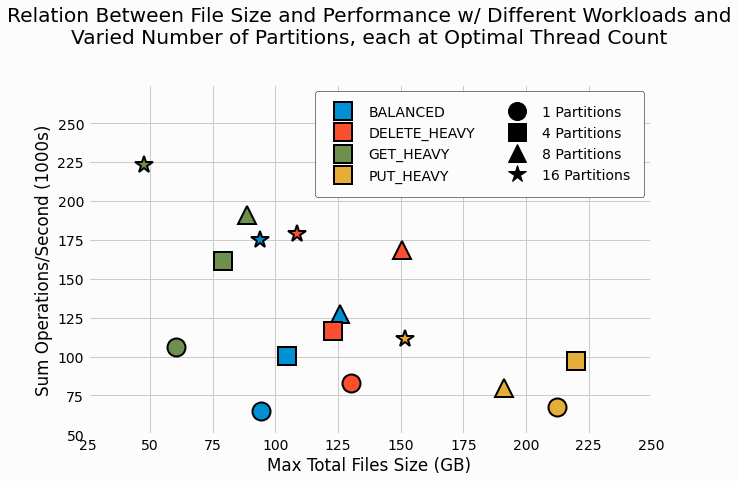

In [18]:

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(1, 1, 1)
for workload, workload_df in normed_results.groupby('workload'):
    color = workload_to_color[workload]
    for partition, partition_df in workload_df.reset_index().groupby('partitions'):
        row = partition_df.loc[partition_df['sum'].idxmax()]
        ax.plot([row['final_file_size']], [row['sum']],
                 color=color, marker=partition_to_marker[partition],
                 ms=18, mew=2, mec='k', alpha=1)
    ax.plot([-1], [-1], color=color, ls='None', ms=18, mew=2, mec='k', marker='s', label=f'{workload}')
    

for partition, marker in partition_to_marker.items():
    ax.plot([-1], [-1], marker=marker, color='k', ls='None', ms=18, label=f'{partition} Partitions')


ax.set_xlabel('Max Total Files Size (GB)')
ax.set_ylabel('Sum Operations/Second (1000s)')
ax.legend(loc='upper right', frameon=True, framealpha=1, edgecolor='k', borderpad=1, ncol=2)
ax.set_xlim(25, 250)
ax.set_ylim(50, 275)
ax.set_yticks(np.arange(50, 251, 25))
ax.set_title('Relation Between File Size and Performance w/ Different Workloads and'
             '\nVaried Number of Partitions, each at Optimal Thread Count', y=1.1)
plt.savefig(figdir + '/performance_file_size_relation.png', bbox_inches='tight')

# Time Dependent Analysis

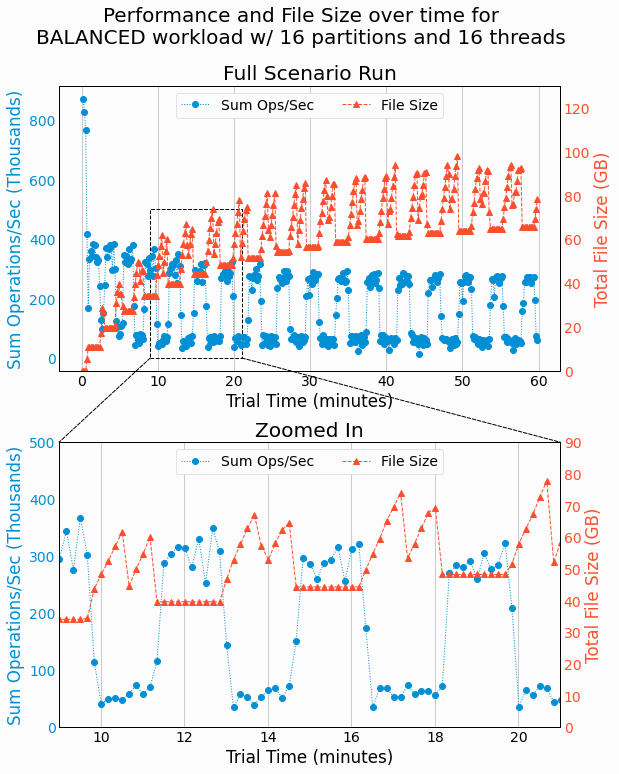

In [19]:
import matplotlib.patches as patches

def diff(x):
    return x.iloc[1::].reset_index(drop=True) - x.iloc[:-1:].reset_index(drop=True)

def prepare_t_ops_sec(workload, partitions, thread_count):
    r = grouped_results
    r = r[r['workload'] == workload]
    r = r[r['partitions'] == partitions]
    r = r[r['thread_count'] == thread_count]
    assert len(r) == 1
    r = r.iloc[0]
    x = r['results']
    x = x.copy()

    t = x['t'] / 60
    ops_sec = (x[['put', 'get', 'delete']].sum(axis=1).iloc[1::].reset_index(drop=True) /
                diff(x['t']))
    ops_sec /= 1000
    return r, t, ops_sec, x['file_size'] / 1e9
    
def plot_ops_size_one(t, ops_sec, file_size, ax1):
    ax2 = ax1.twinx()

    l1, = ax1.plot(t[1::], ops_sec, color=colors[0], label='Sum Ops/Sec', marker='o', lw=1, ls=':')
    l2, = ax2.plot(t, file_size, color=colors[1], label='File Size', marker='^', lw=1, ls='--')

    ax1.grid(False, axis='y')
    ax2.grid(False, axis='y')
    ax1.legend([l1, l2], [l1.get_label(), l2.get_label()],
               loc='upper center', ncol=2, framealpha=1)
    ax1.set_ylabel('Sum Operations/Sec (Thousands)', color=colors[0])
    ax1.tick_params(axis='y', colors=colors[0])
    ax2.set_ylabel('Total File Size (GB)', color=colors[1])
    ax2.tick_params(axis='y', colors=colors[1])
    ax1.set_xlabel('Trial Time (minutes)')
    return ax2

def plot_time_dependence_zoom(workload, partitions, thread_count,
                              t_start, t_end, ops_lim, file_lim_full, file_lim_zoom):
    r, t, ops_sec, file_size = prepare_t_ops_sec(workload, partitions, thread_count)
    
    def plot_ops_size(index):
        ax1 = fig.add_subplot(2, 1, index)
        ax2 = plot_ops_size_one(t, ops_sec, file_size, ax1)
        return ax1, ax2

    with plt.rc_context({'axes.edgecolor':'k', 'axes.linewidth':1}):
        fig = plt.figure(figsize=(8,11))
        fig.subplots_adjust(hspace=0.25)

        ax1f, ax2f = plot_ops_size(1)
        rect = patches.Rectangle((t_start,0), max(5, t_end - t_start), ops_lim,
                                 linewidth=1, edgecolor='k', facecolor='none', ls='--')
        ax1f.add_patch(rect)
        ax1f.set_title('Full Scenario Run')
        ax2f.set_ylim(0, file_lim_full)

        ax1z, ax2z = plot_ops_size(2)
        ax1z.set_title('Zoomed In')


        for a,b in [[(t_start,0), (t_start, ops_lim)], [(t_end,0), (t_end, ops_lim)]]:
            conn = patches.Cocon = patches.ConnectionPatch(xyA=a, xyB=b, coordsA="data", coordsB="data",
                                                           axesA=ax1f, axesB=ax1z, color='k', lw=1, ls='--')
            ax1f.add_artist(conn)

        ax1z.set_xlim(t_start, t_end)
        ax1z.set_ylim(0, ops_lim)
        ax2z.set_ylim(0, file_lim_zoom)

        fig.suptitle('Performance and File Size over time for\n' +
                     f'{r["workload"]} workload w/ {r["partitions"]} partitions and {r["thread_count"]} threads'
                     ,y=0.98, size=20)
        
    return fig, ax1f, ax2f, ax1z, ax2z
        
        

plot_time_dependence_zoom('BALANCED', partitions=16, thread_count=16,
                          t_start=9, t_end=21, ops_lim=500, file_lim_full=130, file_lim_zoom=90)
plt.savefig(figdir + '/time_dependent_balanced_16partitions_16_threads.png', bbox_inches='tight')


In [20]:
def plot_time_dependence(workload, partitions, thread_count):
    r, t, ops_sec, file_size = prepare_t_ops_sec(workload, partitions, thread_count)

    with plt.rc_context({'axes.edgecolor':'k', 'axes.linewidth':1}):
        fig = plt.figure(figsize=(8, 5))
        ax1 = fig.add_subplot(1, 1, 1)
        ax2 = plot_ops_size_one(t, ops_sec, file_size, ax1)
        fig.suptitle('Performance and File Size over time for\n' +
                     f'{r["workload"]} workload w/ {r["partitions"]} partitions and {r["thread_count"]} threads'
                     ,y=1.05, size=20)
        
    return fig, ax1, ax2



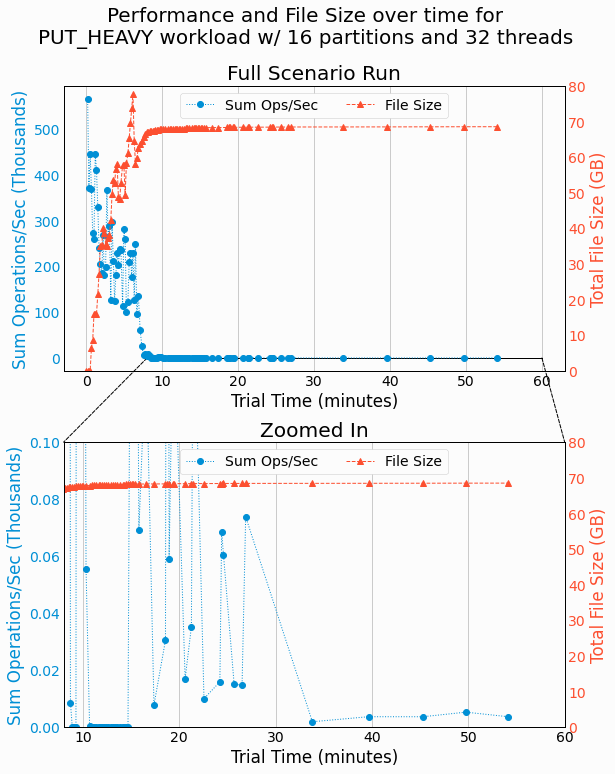

In [21]:
fig, ax1f, ax2f, ax1z, ax2z = plot_time_dependence_zoom(
    'PUT_HEAVY', partitions=16, thread_count=32,
    t_start=8, t_end=60, ops_lim=0.1, file_lim_full=80, file_lim_zoom=80)

plt.savefig(figdir + '/time_dependent_put_heavy_16partitions_32threads.png', bbox_inches='tight')


# Find All Hung Cases

,count,mean,std,min,0%,5%,10%,25%,50%,max
results,80.0,3.906049,2.627695,0.0,0.0,0.770565,0.988862,2.205767,3.326218,14.551067


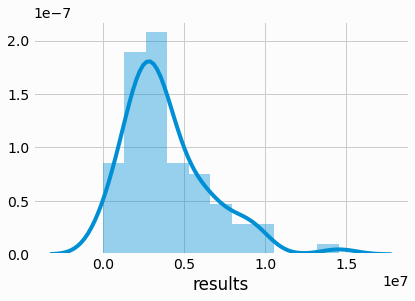

In [22]:
def comp_final_ops(x):
    return x[['put', 'get', 'delete']].iloc[-5::].sum().sum()


final_ops = grouped_results['results'].map(comp_final_ops)
display(final_ops.div(1e6).describe(percentiles=[0, 0.05, 0.1, 0.25, 0.5]).to_frame().T)
sns.distplot(final_ops)

In [23]:
final_ops.sort_values()[:10]

cf616d63-8c9f-11ea-b1d1-00155d010301          0
cf616d62-8c9f-11ea-b1d1-00155d010301       5091
cf616d64-8c9f-11ea-b1d1-00155d010301       5762
58db5272-8a7c-11ea-b1d1-00155d010301     732110
5b6b2917-8ac6-11ea-b1d1-00155d010301     772589
58db5273-8a7c-11ea-b1d1-00155d010301     869662
5aa705b6-8ac6-11ea-b1d1-00155d010301     871194
58db527a-8a7c-11ea-b1d1-00155d010301     872546
0dfc0d2f-8c76-11ea-b1d1-00155d010301    1001786
5b6b2912-8ac6-11ea-b1d1-00155d010301    1652784
Name: results, dtype: int64

In [24]:
grouped_results.loc[final_ops[final_ops < 100 * 1000].index]

,status,partitions,thread_count,workload,results,final_file_size,sum_put,sum_get,sum_delete
cf616d63-8c9f-11ea-b1d1-00155d010301,succeeded,16,16,PUT_HEAVY,delete get_found spec_id delete_found get file_si...,1.295589e+11,214203963.0,11896769.0,11894307.0
cf616d64-8c9f-11ea-b1d1-00155d010301,succeeded,16,32,PUT_HEAVY,delete get_found spec_id delete_found get file_siz...,6.851533e+10,96797730.0,5377495.0,5377613.0
cf616d62-8c9f-11ea-b1d1-00155d010301,succeeded,8,32,PUT_HEAVY,delete get_found spec_id delete_found get file_si...,1.851825e+11,219260657.0,12182275.0,12177786.0


In [25]:
final_ops[final_ops < 100 * 1000]

cf616d63-8c9f-11ea-b1d1-00155d010301       0
cf616d64-8c9f-11ea-b1d1-00155d010301    5762
cf616d62-8c9f-11ea-b1d1-00155d010301    5091
Name: results, dtype: int64